In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz")

In [3]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)


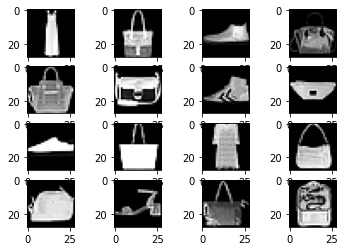

In [4]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        img = trainxs[np.random.randint(0, len(trainxs))]
        axarr[i, j].imshow(img)

## 3.3 Implementing the algorithm

In [18]:
def sigmoid(z):
    """Compute the logistic function"""
    return 1. / (1. + np.exp(-z))
def sigmoid_d(z):
    """Compute derivative of the logistic function"""
    fz = sigmoid(x)
    return fz * (1 - fz)
def loss(yhat, y):
    """Single sample log-likelihood loss"""
    if yhat in (0, 1): # Check if sample will cause ln(0)
        return np.array([[0]])
    return (-y * np.log(yhat)) - ((1 - y) * np.log(1 - yhat))

In [6]:
def forward(params, x):
    """Compute forward pass"""
    x = x.reshape(28**2, 1) # Place sample into single vector
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["w2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    
    return forward_res

def backprop(x, y, params):
    """Compute gradients analytically"""
    x = x.reshape(28**2, 1)
    # Forward Pass
    fwd_pass = forward(params, x)
    
    # Backwards Pass
    dL_dz2 = (fwd_pass["a2"] - y)
    dL_dz1 = dL_dz2 * params["w2"].T * sigmoid_d(fwd_pass["z1"])
    
    grad = {}
    grad["w2"] = dL_dz2 * fwd_pass["a1"].T
    grad["b2"] = dL_dz2
    grad["W1"] = dL_dz1 @ x.T
    grad["b1"] = dL_dz1

    return grad

In [7]:
def predict_raw(x, params):
    """Get raw model activation for given training sample"""
    forward_res = forward(params, x)
    return forward_res["a2"]

def predict_class(yhat):
    """Get class prediction for given activation"""
    if yhat >= 0.5:
        return 1
    return 0

In [8]:
def nvalidate(xs, ys, params):
    """Returns (Dataset Loss, Dataset Accuracy)"""
    l, accuracy = 0, 0
    nData = xs.shape[0]
    for i in range(nData):
        yhat = predict_raw(xs[i], params) # Raw activation
        y_pred = predict_class(yhat) # Class prediction (binary)
        # Add Log Likelihood Loss
        if yhat not in (0, 1):
            l += (-ys[i] * np.log(yhat)) - ((1 - ys[i]) * np.log(1 - yhat))
        if y_pred == ys[i]:
            accuracy += 1
    return l.item() / nData, accuracy / nData       

In [12]:
def trainTwoLayerPerceptron(
    xs, ys, devxs, devys, 
    n_epochs=3, learning_rate=0.1, 
    momentum=0, batch_size=0, h=19
):
    """Initialize and train 2 Layer Perceptron on a dataset, 
    generating performance metrics at each epoch
    Returns: (epochs, t_losses, t_accs, v_losses, v_accs, params)
    """
    # Initialize Hyperparameters
    img_size = 28**2
    out_size = 1
    nData = xs.shape[0]
    
    lr = learning_rate
    a = momentum # alpha
    
    # batch_size of 0 is full batch (batch_size 1 is s.g.d.)
    if batch_size == 0:
        batch_size = nData
    
    # Show model hyperparameters for debugging
    print("nData:", nData, 
          "Hidden Layer size:", h, "Learning Rate:", lr, 
          "Momentum:", momentum, "Batch Size:", batch_size)
    
    # Initialize training metadata containers
    epochs = []
    t_losses, v_losses = [], []
    t_accs, v_accs = [], []
    
    # Initialize model parameters
    params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h, 1)),
              "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
              "b2": np.zeros((out_size, 1))}
    
    # Initialize Grad vector
    grad = {}
    # Initialize Update Vector nu
    for theta in params:
        v[theta] = np.zeros_like(params[theta])
    
    # Start training process
    for epoch in range(n_epochs):
        epochs.append(epoch)
        print("----------------------------------\nEpoch:", epoch)
        
        v_loss, v_acc = nvalidate(devxs, devys, params)
        v_accs.append(v_acc)
        v_losses.append(v_loss)
        t_loss, t_acc = nvalidate(xs, ys, params)
        t_accs.append(t_acc)
        t_losses.append(t_loss)
        print("Val Acc:", v_acc, "Val Loss:", v_loss)

        # Randomly shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        # Get array of arrays containing batch_size array indices
        batch_indices = np.split(np.arange(nData), (nData // batch_size))
        
        for batch in batch_indices:
            # Initialize gradients to zero
            for theta in params:
                grad[theta] = np.zeros_like(params[theta])
            
            for i in batch:
                grad_i = backprop(trainxs_shuffled[i], trainys_shuffled[i], params)
                
                # Update batch gradient with incremental gradient
                for theta in grad_i:
                    grad[theta] += grad_i[theta] / batch_size
            
            # Perform exponentially averaged momentum update
            for theta in v:
                v[theta] = a * v[theta] + (1-a) * grad[theta]
            
            # Perform model parameter update
            for theta in params:
                params[theta] -= lr * v[theta]
        
    return epochs, t_losses, t_accs, v_losses, v_accs, params

In [16]:
_ = mlp(
        trainxs, trainys,
        devxs, devys,
        n_epochs=5,
        learning_rate=0.1,
        momentum=0.4,
        batch_size=8,
        h=200,
    )

nData: 12000 Hidden Layer size: 200 Learning Rate: 0.1 Momentum: 0.4 Batch Size: 8
----------------------------------
Epoch: 0
Val Acc: 0.495 Val Loss: 0.8006424224788421
----------------------------------
Epoch: 1
Val Acc: 0.973 Val Loss: 0.09724185116350519
----------------------------------
Epoch: 2
Val Acc: 0.971 Val Loss: 0.0826151502939925
----------------------------------
Epoch: 3
Val Acc: 0.981 Val Loss: 0.06639514588242866
----------------------------------
Epoch: 4
Val Acc: 0.982 Val Loss: 0.06261702454651229


In [17]:
nn_gridsearch = {}
with open("gridsearch_monolith_2lp.p", "rb") as fp:
    nn_gridsearch = pickle.load(fp)
len(nn_gridsearch)

60

In [ ]:
mts = [0, 0.2, 0.4] # momentum
lrs = [0.1, 0.01, 0.001] # learning rate
bzs = [1, 8, 1000, 12000] # batch size
hzs = [19, 41] # hidden layer size
n_epochs = 50 # number of epochs
for hz in hzs:
    for mt in mts:
        for lr in lrs:
            for bz in bzs:
                key = "hids{}_momt{}_lr{}_bchsz{}_epch{}".format(hz, mt, lr, bz, n_epochs)
                print("Running", key)
                if lr < 0.1 and bz > 2000:
                    print("Skipping", key)
                    continue
                if key in nn_gridsearch.keys():
                    print("Skipping", key)
                    continue
                nn_gridsearch[key] = mlp(
                    trainxs, trainys,
                    devxs, devys,
                    n_epochs=n_epochs,
                    learning_rate=lr,
                    momentum=mt,
                    batch_size=bz,
                    h=hz,
                )
                with open("gridsearch_monolith_2lp.p", "wb") as fp:
                    pickle.dump(nn_gridsearch, fp, protocol=pickle.HIGHEST_PROTOCOL)